# A dynamic task assignment model for an emergency rescue based on multi-agent reinforcement learning

## Pseudocódigo del Algoritmo Greedy

### Descripción
El algoritmo busca $Z = \max \left( \sum_{t=0}^{T} r_t \right)$, dado lo siguiente:

$
r_t = f \cdot v_t \cdot \left( 
\sum_{\text{task}_i \in \text{Task}} 
\sum_{\text{node}_j \in \text{Node}} 
\frac{D_{i,j,t}}{|D_{i,j,t}|}
\right)
$

### Variables
- $ N $: conjunto de nodos (ubicaciones de rescate).
- $ T $: conjunto de tareas.
- $ H $: conjunto de helicópteros.
- $t_{\text{current}}$: tiempo actual de la simulación.
- $ f(t) $: satisfacción temporal, definida como:
  $
  f(t^*) =
  \begin{cases} 
    1 & \text{si } t^* \leq t_1, \\
    0.5 \cdot \frac{t_2 - t^*}{t_2 - t_1} & \text{si } t_1 < t^* \leq t_2, \\
    0.5 \cdot \frac{t^* - t_2}{t_{\text{max}} - t_2} & \text{si } t_2 < t^* \leq t_{\text{max}}, \\
    0 & \text{si } t^* > t_{\text{max}}.
  \end{cases}
  $
- $ v_t $: relación de tareas completadas respecto al total:
  $
  v_t = \frac{1}{\text{total\_tasks}}
  $
- $ D_{i,j,t} $: variable de decisión, indicando si la tarea $ i $ se asigna al nodo $ j $ en el tiempo $ t $.

### Pseudocódigo
1. **Inicializar** los nodos $ N $, tareas $ T $, y helicópteros $ H $.
2. Calcular $ \text{total\_tasks} = |T| $.

3. Para cada helicóptero $ h \in H $:
    $ n_{\text{current}} = n_{\text{base}} $ y $ t_{\text{current}} = 0 $.

4. **While** $ t_{\text{current}} < T_{\text{total}} $:
    - Para cada tarea $ t_i \in T $:
        - **If** $ t_i $ no está completada:
            - Calcular:
              - Distancia:
                $
                d = \text{distancia}(n_{\text{current}}, n_{\text{t_i}})
                $
              - Tiempo de viaje:
                $
                t_{\text{travel}} = \frac{d}{\text{speed}_h}
                $
              - Tiempo de finalización:
                $
                t_{\text{completion}} = t_{\text{current}} + t_{\text{travel}}
                $
            - Evaluar si el helicóptero $ h $ puede completar la tarea $ t_i $ bajo las restricciones (capacidad, tiempos).
            - Calcular el beneficio:
                $
                r_{\text{t}} = f(t_{\text{completion}}) \cdot v_t
                $
    - Seleccionar la tarea $ t_i $ con el mayor beneficio.
    - Actualizar:
        - $ \text{current\_node} $ al nodo de $ t_i $.
        - Marcar $ t_i $ como completada.
        - Incrementar $ t_{\text{current}} $ por $ t_{\text{travel}} $.

5. **Resultados finales**:
    - Número de tareas completadas:
      $
      \sum_{i} D_{i,j,t}
      $
    - Beneficio total acumulado:
      $
      \text{Total Benefit} = \sum_{\text{tasks completed}} f(t^*) \cdot v_t
      $

6. **Fin del algoritmo**.


In [ ]:
import random
import math
import matplotlib.pyplot as plt

class Node:
    """Represents a node (location) in the rescue graph."""
    def __init__(self, name, x, y):
        self.name = name
        self.x = x  # X-coordinate
        self.y = y  # Y-coordinate
        self.tasks = []  # Tasks at this node

    def add_task(self, task):
        """Add a task to this node."""
        self.tasks.append(task)

    def distance_to(self, other_node):
        """Calculate the distance to another node."""
        return math.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

class Task:
    """Represents a task at a node."""
    def __init__(self, task_id, visual_search, material_transport, medical_assistance, personnel_transfer, optimal_time, effective_time, ineffective_time):
        self.task_id = task_id  # Unique ID for the task
        self.visual_search = visual_search  # True/False if visual search is needed
        self.material_transport = material_transport  # Material weight required (kg)
        self.medical_assistance = medical_assistance  # Number of patients needing assistance
        self.personnel_transfer = personnel_transfer  # Number of personnel to transfer
        self.optimal_time = optimal_time  # Optimal rescue time for maximum benefit
        self.effective_time = effective_time  # Effective rescue time for reduced benefit
        self.ineffective_time = ineffective_time  # Time after which no benefit is awarded
        self.is_completed = False  # Track if task is completed
        self.completion_time = None  # Time when the task was completed

    def calculate_benefit(self, completion_time, total_tasks):
        """
        Calculate the benefit of completing a task.
        completion_time: Time at which the task is completed.
        total_tasks: Total number of tasks in the system (used to calculate v_t).
        """
        # Calculate time satisfaction (f)
        if completion_time <= self.optimal_time:
            f = 1
        elif completion_time <= self.effective_time:
            f = 0.5 * ((self.effective_time - completion_time) / (self.effective_time - self.optimal_time))
        elif completion_time <= self.ineffective_time:
            f = 0.5 * ((completion_time - self.effective_time) / (self.ineffective_time - self.effective_time))
        else:
            f = 0

        # Calculate v_t (task completion ratio)
        v_t = 1 / total_tasks  # Incremental contribution of completing one task
        return f * v_t


class Helicopter:
    """Represents a helicopter in the rescue fleet."""
    def __init__(self, helicopter_id, hovering, visual_search_capability, load_capacity, medical_capacity, passenger_limit, range_km, speed_kmh, position):
        self.helicopter_id = helicopter_id  # Unique ID
        self.hovering = hovering  # Whether it can hover (True/False)
        self.visual_search_capability = visual_search_capability  # True/False if visual search is possible
        self.load_capacity = load_capacity  # Maximum load in kg
        self.medical_capacity = medical_capacity  # Maximum medical assistance capacity
        self.passenger_limit = passenger_limit  # Maximum passengers
        self.range_km = range_km  # Maximum range in km
        self.speed_kmh = speed_kmh  # Speed in km/h
        self.position = position  # Current node (Node object)

    def can_complete_task(self, task):
        """Check if the helicopter can complete a given task."""
        return (
            (not task.visual_search or self.visual_search_capability) and
            self.load_capacity >= task.material_transport and
            self.medical_capacity >= task.medical_assistance and
            self.passenger_limit >= task.personnel_transfer
        )

    def complete_task(self, task, completion_time, total_tasks):
        """Complete a task if resources are sufficient and calculate benefit."""
        if self.can_complete_task(task):
            self.load_capacity -= task.material_transport
            self.medical_capacity -= task.medical_assistance
            self.passenger_limit -= task.personnel_transfer
            task.is_completed = True
            task.completion_time = completion_time
            # Pass total_tasks to calculate_benefit
            return task.calculate_benefit(completion_time, total_tasks)
        return 0

def initialize_graph():
    """Initialize the rescue graph with nodes, tasks, and helicopters."""
    # Define nodes
    central_node = Node("Central Base", 0, 0)  # Centralized base
    nodes = [
        central_node,
        Node("Node A", 10, 5),
        Node("Node B", 20, 15),
        Node("Node C", 30, 10),
        Node("Node D", 40, 20)
    ]

    # Add tasks to nodes
    tasks = [
        Task(task_id=1, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=2, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=3, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=4, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=5, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=6, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=7, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=8, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=9, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=10, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=11, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=12, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=13, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=14, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=15, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=16, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=17, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=18, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=19, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=20, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
    ]
    nodes[1].add_task(tasks[0])
    nodes[1].add_task(tasks[1])
    nodes[1].add_task(tasks[8])
    nodes[1].add_task(tasks[9])
    nodes[2].add_task(tasks[2])
    nodes[2].add_task(tasks[7])
    nodes[2].add_task(tasks[6])
    nodes[2].add_task(tasks[10])
    nodes[2].add_task(tasks[11])
    nodes[2].add_task(tasks[12])
    nodes[2].add_task(tasks[13])
    nodes[3].add_task(tasks[4])
    nodes[3].add_task(tasks[5])
    nodes[3].add_task(tasks[14])
    nodes[3].add_task(tasks[15])
    nodes[4].add_task(tasks[3])
    nodes[4].add_task(tasks[16])
    nodes[4].add_task(tasks[17])
    nodes[4].add_task(tasks[18])
    nodes[4].add_task(tasks[19])

    # Define helicopters stationed at the central base
    helicopters = [
        Helicopter(1, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(2, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(3, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(4, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
    ]

    return nodes, helicopters

def assign_task_with_vt(helicopter, nodes, current_time, total_tasks):
    """
    Assign a task to the helicopter considering the new benefit function.
    """
    best_task = None
    best_task_node = None
    max_benefit = 0

    for node in nodes:
        for task in node.tasks:
            if not task.is_completed:
                # Calculate travel time to the task
                distance = helicopter.position.distance_to(node)
                travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
                completion_time = current_time + travel_time

                # Check if the helicopter can complete the task
                if helicopter.can_complete_task(task):
                    # Calculate adjusted benefit (f * v_t)
                    benefit = task.calculate_benefit(completion_time, total_tasks)
                    if benefit > max_benefit:
                        max_benefit = benefit
                        best_task = task
                        best_task_node = node

    if best_task:
        # Move the helicopter to the task's node
        distance = helicopter.position.distance_to(best_task_node)
        travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
        helicopter.position = best_task_node
        print(
            f"Assigned: Helicopter {helicopter.helicopter_id} to Task {best_task.task_id} at {best_task_node.name}. Flight time: {travel_time:.1f} minutes."
        )
        return best_task, travel_time
    else:
        print(f"No suitable tasks for Helicopter {helicopter.helicopter_id}.")
        return None, 0

def simulate_rescue_with_vt(nodes, helicopters, total_time):
    """
    Simulate the rescue operation with the adjusted benefit function (f * v_t).
    """
    current_time = 0
    total_tasks = sum(len(node.tasks) for node in nodes)  # Total number of tasks
    completed_tasks = 0  # Track completed tasks
    total_benefit = 0
    
    # Data for plotting
    completion_times = []
    individual_benefits = []

    while current_time < total_time:
        for helicopter in helicopters:
            # Assign a task to the helicopter
            task, travel_time = assign_task_with_vt(helicopter, nodes, current_time, total_tasks)

            if task:
                # Update time and track task completion
                current_time += travel_time
                task_completion_time = current_time

                # Complete the task and calculate benefit
                benefit = helicopter.complete_task(task, task_completion_time, total_tasks)
                total_benefit += benefit
                completed_tasks += 1
                
                # Store data for plotting
                completion_times.append(task_completion_time)
                individual_benefits.append(benefit)

                print(
                    f"Task {task.task_id} completed by Helicopter {helicopter.helicopter_id} at time {task_completion_time:.1f} minutes. Benefit: {benefit:.4f}"
                )

        # Increment the simulation time (if no tasks are assigned)
        current_time += 1

    print(f"\nSimulation completed. \nTotal tasks completed: {completed_tasks}/{total_tasks}. \nTotal benefit: {total_benefit:.4f}")
    
    # Calculate cumulative benefits
    cumulative_benefits = []
    total = 0
    for b in individual_benefits:
        total += b
        cumulative_benefits.append(total)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(completion_times, cumulative_benefits, marker="o", linestyle="-", label="Cumulative Benefit")
    plt.title("Cumulative Benefit Over Time - Greedy Algorithm", fontsize=14)
    plt.xlabel("Time (minutes)", fontsize=12)
    plt.ylabel("Cumulative Benefit", fontsize=12)
    plt.ylim(0, 0.6)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Initialize the rescue graph
nodes, helicopters = initialize_graph()

# Run the simulation
simulate_rescue_with_vt(nodes, helicopters, total_time=38)

H1 → T1  fin=10.5′  ΔB=0.050
H2 → T2  fin=10.5′  ΔB=0.050
H3 → T9  fin=10.5′  ΔB=0.050
H4 → T10  fin=10.5′  ΔB=0.050
H1 → T8  fin=22.1′  ΔB=0.050
H2 → T7  fin=22.1′  ΔB=0.050
H3 → T12  fin=22.1′  ΔB=0.050
H4 → T15  fin=24.7′  ΔB=0.050
H1 → T13  fin=28.1′  ΔB=0.046
H2 → T4  fin=36.4′  ΔB=0.042
H3 → T19  fin=36.4′  ΔB=0.042
H1 → T5  fin=38.6′  ΔB=0.033
H3 → T17  fin=42.4′  ΔB=0.028
H1 → T16  fin=44.6′  ΔB=0.025
H3 → T20  fin=48.4′  ΔB=0.023
H1 → T6  fin=50.6′  ΔB=0.018
H3 → T18  fin=54.4′  ΔB=0.017
H1 → T14  fin=61.1′  ΔB=0.016

► Tareas completadas: 18/20
► Beneficio total    : 0.691



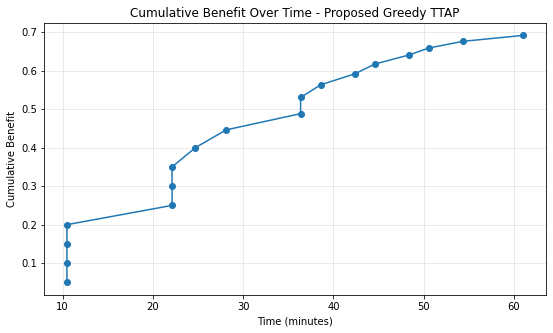

In [23]:
import math
import matplotlib.pyplot as plt
from typing import List

# ------------------------------------------------------------------
SERVICE_TIME = 6          # minutos (fijo, puedes cambiar)

# ----------  (Clases Node, Task, Helicopter idénticas a las tuyas)

class Node:
    def __init__(self, name, x, y):
        self.name, self.x, self.y = name, x, y
        self.tasks: List[Task] = []

    def add_task(self, task): self.tasks.append(task)
    def distance_to(self, o): return math.hypot(self.x - o.x, self.y - o.y)

class Task:
    def __init__(self, task_id, visual_search, material_transport, medical_assistance,
                 personnel_transfer, optimal_time, effective_time, ineffective_time):
        self.task_id, self.visual_search = task_id, visual_search
        self.material_transport, self.medical_assistance = material_transport, medical_assistance
        self.personnel_transfer = personnel_transfer
        self.optimal_time, self.effective_time, self.ineffective_time = (
            optimal_time, effective_time, ineffective_time)
        self.is_completed, self.completion_time = False, None

    def calculate_benefit(self, t_finish, n_total):
        if t_finish <= self.optimal_time:          f = 1.0
        elif t_finish <= self.effective_time:      # lineal 1 → 0.5
            f = 1 - 0.5 * (t_finish - self.optimal_time) / (self.effective_time - self.optimal_time)
        elif t_finish <= self.ineffective_time:    # lineal 0.5 → 0
            f = 0.5 * (self.ineffective_time - t_finish) / (self.ineffective_time - self.effective_time)
        else:                                      f = 0.0
        return f * (1 / n_total)

class Helicopter:
    def __init__(self, hid, hovering, visual_search_capability,
                 load_capacity, medical_capacity, passenger_limit,
                 range_km, speed_kmh, position):
        self.helicopter_id = hid
        self.hovering, self.visual_search_capability = hovering, visual_search_capability
        self.load_capacity, self.medical_capacity = load_capacity, medical_capacity
        self.passenger_limit, self.range_km, self.speed_kmh = passenger_limit, range_km, speed_kmh
        self.position = position
        self.available_time = 0     # inicializado aquí
        self.blocked = False

    def can_complete_task(self, t: Task):
        return ((not t.visual_search or self.visual_search_capability)
                and self.load_capacity >= t.material_transport
                and self.medical_capacity >= t.medical_assistance
                and self.passenger_limit >= t.personnel_transfer)

    def execute_task(self, t: Task, t_finish: float, n_total: int):
        # --- si quieres descontar recursos reales, activa las 3 líneas siguientes
        self.load_capacity   -= t.material_transport
        self.medical_capacity-= t.medical_assistance
        self.passenger_limit -= t.personnel_transfer
        t.is_completed, t.completion_time = True, t_finish
        return t.calculate_benefit(t_finish, n_total)


# ------------------------------------------------------------------
def initialize_graph():
    """Initialize the rescue graph with nodes, tasks, and helicopters."""
    # Define nodes
    central_node = Node("Central Base", 0, 0)  # Centralized base
    nodes = [
        central_node,
        Node("Node A", 10, 5),
        Node("Node B", 20, 15),
        Node("Node C", 30, 10),
        Node("Node D", 40, 20)
    ]

    # Add tasks to nodes
    tasks = [
        Task(task_id=1, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=2, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=3, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=4, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=5, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=6, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=7, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=8, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=9, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=10, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=11, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=12, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=13, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=14, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=15, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=16, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=17, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=18, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=19, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=20, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
    ]
    nodes[1].add_task(tasks[0])
    nodes[1].add_task(tasks[1])
    nodes[1].add_task(tasks[8])
    nodes[1].add_task(tasks[9])
    nodes[2].add_task(tasks[2])
    nodes[2].add_task(tasks[7])
    nodes[2].add_task(tasks[6])
    nodes[2].add_task(tasks[10])
    nodes[2].add_task(tasks[11])
    nodes[2].add_task(tasks[12])
    nodes[2].add_task(tasks[13])
    nodes[3].add_task(tasks[4])
    nodes[3].add_task(tasks[5])
    nodes[3].add_task(tasks[14])
    nodes[3].add_task(tasks[15])
    nodes[4].add_task(tasks[3])
    nodes[4].add_task(tasks[16])
    nodes[4].add_task(tasks[17])
    nodes[4].add_task(tasks[18])
    nodes[4].add_task(tasks[19])

    # Define helicopters stationed at the central base
    helicopters = [
        Helicopter(1, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(2, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(3, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(4, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
    ]

    return nodes, helicopters

# ------------------------------------------------------------------
def next_available(helicopters):
    active = [h for h in helicopters if not h.blocked]
    return min(active, key=lambda h: h.available_time, default=None)

def simulate(nodes, helicopters, T_max):
    n_total = sum(len(n.tasks) for n in nodes)
    pending, B = n_total, 0.0

    completion_times, individual_benefits = [], []

    while pending and (h := next_available(helicopters)) and h.available_time < T_max:
        t_now = h.available_time
        best, best_node, best_benefit, best_tau = None, None, 0, 0

        # --- buscar la mejor tarea para este helicóptero
        for n in nodes:
            for task in n.tasks:
                if task.is_completed or not h.can_complete_task(task):
                    continue
                tau = h.position.distance_to(n) / h.speed_kmh * 60
                t_finish = t_now + tau + SERVICE_TIME
                if t_finish >= T_max:
                    continue
                benefit = task.calculate_benefit(t_finish, n_total)
                if benefit > best_benefit:
                    best, best_node = task, n
                    best_benefit, best_tau = benefit, tau

        if best:  # asignar
            h.position = best_node
            h.available_time = t_now + best_tau + SERVICE_TIME
            B += best_benefit
            pending -= 1
            individual_benefits.append(best_benefit)
            completion_times.append(h.available_time)
            best.is_completed = True
            print(f"H{h.helicopter_id} → T{best.task_id}  fin={h.available_time:.1f}′  ΔB={best_benefit:.3f}")
        else:
            h.blocked = True   # No hay tarea factible

    print(f"\n► Tareas completadas: {n_total - pending}/{n_total}")
    print(f"► Beneficio total    : {B:.3f}\n")
    plot_cumulative(completion_times, individual_benefits)

def plot_cumulative(times, deltas):
    cum, y = 0, []
    for d in deltas:
        cum += d
        y.append(cum)
    plt.figure(figsize=(9,5))
    plt.plot(times, y, marker='o')
    plt.xlabel("Time (minutes)")
    plt.ylabel("Cumulative Benefit")
    plt.title("Cumulative Benefit Over Time - Proposed Greedy TTAP")
    plt.grid(alpha=.3)
    plt.show()

# ------------------------------------------------------------------
if __name__ == "__main__":
    nodes, helicopters = initialize_graph()
    simulate(nodes, helicopters, T_max=120)   # 120 min de horizonte


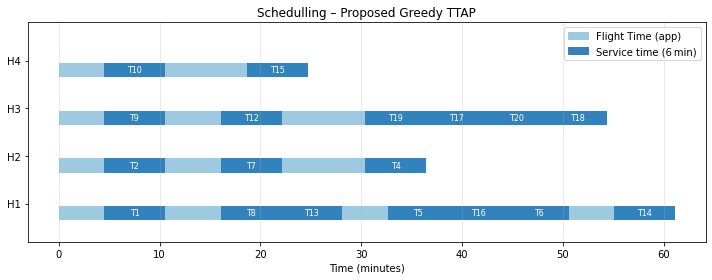

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ───────────────────────────────────────────────────────────
# Raw lines copied from the user's result log
raw_log = """
H1 → T1  fin=10.5  ΔB=0.050
H2 → T2  fin=10.5  ΔB=0.050
H3 → T9  fin=10.5  ΔB=0.050
H4 → T10  fin=10.5  ΔB=0.050
H1 → T8  fin=22.1  ΔB=0.050
H2 → T7  fin=22.1  ΔB=0.050
H3 → T12  fin=22.1  ΔB=0.050
H4 → T15  fin=24.7  ΔB=0.050
H1 → T13  fin=28.1  ΔB=0.046
H2 → T4  fin=36.4  ΔB=0.042
H3 → T19  fin=36.4  ΔB=0.042
H1 → T5  fin=38.6  ΔB=0.033
H3 → T17  fin=42.4  ΔB=0.028
H1 → T16  fin=44.6  ΔB=0.025
H3 → T20  fin=48.4  ΔB=0.023
H1 → T6  fin=50.6  ΔB=0.018
H3 → T18  fin=54.4  ΔB=0.017
H1 → T14  fin=61.1  ΔB=0.016
"""

# ───────────────────────────────────────────────────────────
# Parse lines into structured records
records = []
for line in raw_log.strip().splitlines():
    line = line.strip()
    if not line:
        continue
    parts = line.split()
    heli = int(parts[0][1:])               # Hn
    task = int(parts[2][1:])               # Tn (arrow is a unicode arrow)
    # fin value may be adjacent to ΔB or separated; find token that starts with 'fin='
    fin_token = next(p for p in parts if p.startswith('fin='))
    finish = float(fin_token.split('=')[1])
    records.append(dict(heli=heli, task=task, finish=finish))

# Sort by helicopter then finish
records.sort(key=lambda r: (r['heli'], r['finish']))

# Compute start times and travel durations (approx.) assuming SERVICE_TIME = 10 min
SERVICE_TIME = 6.0
prev_finish = {1:0.0, 2:0.0, 3:0.0, 4:0.0}
for rec in records:
    start = prev_finish[rec['heli']]
    travel = max(0.0, rec['finish'] - start - SERVICE_TIME)
    rec['start'] = start
    rec['travel'] = travel
    prev_finish[rec['heli']] = rec['finish']

# ───────────────────────────────────────────────────────────
# Build Gantt chart
fig, ax = plt.subplots(figsize=(10,4))
colors = dict(travel="#9ecae1", service="#3182bd")

for idx, rec in enumerate(records):
    y = rec['heli']
    # travel bar
    ax.broken_barh([(rec['start'], rec['travel'])], (y-0.35, 0.3),
                   facecolors=colors['travel'])
    # service bar
    ax.broken_barh([(rec['start']+rec['travel'], SERVICE_TIME)], (y-0.35, 0.3),
                   facecolors=colors['service'])
    # task label centred on service bar
    ax.text(rec['start']+rec['travel']+SERVICE_TIME/2, y-0.35+0.15,
            f"T{rec['task']}", ha='center', va='center', color='white', fontsize=8)

# Aesthetics
ax.set_xlabel("Time (minutes)")
ax.set_yticks([1,2,3,4])
ax.set_yticklabels([f"H{i}" for i in [1,2,3,4]])
ax.set_title("Schedulling – Proposed Greedy TTAP")

ax.grid(axis='x', alpha=0.3)
ax.set_ylim(0.2,4.8)

leg_patches = [mpatches.Patch(color=colors['travel'], label="Flight Time (app)"),
               mpatches.Patch(color=colors['service'], label="Service time (6 min)")]
ax.legend(handles=leg_patches, loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
#Sigmoid Function as a Decay Function

In [ ]:
import random
import math
import matplotlib.pyplot as plt

class Node:
    """Represents a node (location) in the rescue graph."""
    def __init__(self, name, x, y):
        self.name = name
        self.x = x  # X-coordinate
        self.y = y  # Y-coordinate
        self.tasks = []  # Tasks at this node

    def add_task(self, task):
        """Add a task to this node."""
        self.tasks.append(task)

    def distance_to(self, other_node):
        """Calculate the distance to another node."""
        return math.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

class Task:
    """Represents a task at a node."""
    def __init__(self, task_id, visual_search, material_transport, medical_assistance, personnel_transfer, optimal_time, effective_time, ineffective_time):
        self.task_id = task_id  # Unique ID for the task
        self.visual_search = visual_search  # True/False if visual search is needed
        self.material_transport = material_transport  # Material weight required (kg)
        self.medical_assistance = medical_assistance  # Number of patients needing assistance
        self.personnel_transfer = personnel_transfer  # Number of personnel to transfer
        self.optimal_time = optimal_time  # Optimal rescue time for maximum benefit
        self.effective_time = effective_time  # Effective rescue time for reduced benefit
        self.ineffective_time = ineffective_time  # Time after which no benefit is awarded
        self.is_completed = False  # Track if task is completed
        self.completion_time = None  # Time when the task was completed

    def calculate_benefit(self, completion_time, total_tasks):
        """
        Calculate benefit using a sigmoid decay function between t_optimal and t_ineffective.
        """
        alpha = 0.2  # Steepness of the decay
        if completion_time <= self.optimal_time:
            f = 1
        elif completion_time >= self.ineffective_time:
            f = 0
        else:
            f = 1 / (1 + math.exp(alpha * (completion_time - self.effective_time)))

        v_t = 1 / total_tasks
        return f * v_t

class Helicopter:
    """Represents a helicopter in the rescue fleet."""
    def __init__(self, helicopter_id, hovering, visual_search_capability, load_capacity, medical_capacity, passenger_limit, range_km, speed_kmh, position):
        self.helicopter_id = helicopter_id  # Unique ID
        self.hovering = hovering  # Whether it can hover (True/False)
        self.visual_search_capability = visual_search_capability  # True/False if visual search is possible
        self.load_capacity = load_capacity  # Maximum load in kg
        self.medical_capacity = medical_capacity  # Maximum medical assistance capacity
        self.passenger_limit = passenger_limit  # Maximum passengers
        self.range_km = range_km  # Maximum range in km
        self.speed_kmh = speed_kmh  # Speed in km/h
        self.position = position  # Current node (Node object)

    def can_complete_task(self, task):
        """Check if the helicopter can complete a given task."""
        return (
            (not task.visual_search or self.visual_search_capability) and
            self.load_capacity >= task.material_transport and
            self.medical_capacity >= task.medical_assistance and
            self.passenger_limit >= task.personnel_transfer
        )

    def complete_task(self, task, completion_time, total_tasks):
        """Complete a task if resources are sufficient and calculate benefit."""
        if self.can_complete_task(task):
            self.load_capacity -= task.material_transport
            self.medical_capacity -= task.medical_assistance
            self.passenger_limit -= task.personnel_transfer
            task.is_completed = True
            task.completion_time = completion_time
            # Pass total_tasks to calculate_benefit
            return task.calculate_benefit(completion_time, total_tasks)
        return 0

def initialize_graph():
    """Initialize the rescue graph with nodes, tasks, and helicopters."""
    # Define nodes
    central_node = Node("Central Base", 0, 0)  # Centralized base
    nodes = [
        central_node,
        Node("Node A", 10, 5),
        Node("Node B", 20, 15),
        Node("Node C", 30, 10),
        Node("Node D", 40, 20)
    ]

    # Add tasks to nodes
    tasks = [
        Task(task_id=1, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=2, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=3, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=4, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=5, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=6, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=7, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=8, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=9, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=10, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=11, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=12, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=13, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=14, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=15, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=16, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
        Task(task_id=17, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),
        Task(task_id=18, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=120),
        Task(task_id=19, visual_search=False, material_transport=400, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=90),
        Task(task_id=20, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=100),
    ]
    nodes[1].add_task(tasks[0])
    nodes[1].add_task(tasks[1])
    nodes[1].add_task(tasks[8])
    nodes[1].add_task(tasks[9])
    nodes[2].add_task(tasks[2])
    nodes[2].add_task(tasks[7])
    nodes[2].add_task(tasks[6])
    nodes[2].add_task(tasks[10])
    nodes[2].add_task(tasks[11])
    nodes[2].add_task(tasks[12])
    nodes[2].add_task(tasks[13])
    nodes[3].add_task(tasks[4])
    nodes[3].add_task(tasks[5])
    nodes[3].add_task(tasks[14])
    nodes[3].add_task(tasks[15])
    nodes[4].add_task(tasks[3])
    nodes[4].add_task(tasks[16])
    nodes[4].add_task(tasks[17])
    nodes[4].add_task(tasks[18])
    nodes[4].add_task(tasks[19])

    # Define helicopters stationed at the central base
    helicopters = [
        Helicopter(1, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(2, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(3, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(4, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
    ]

    return nodes, helicopters

def assign_task_with_vt(helicopter, nodes, current_time, total_tasks):
    """
    Assign a task to the helicopter considering the new benefit function.
    """
    best_task = None
    best_task_node = None
    max_benefit = 0

    for node in nodes:
        for task in node.tasks:
            if not task.is_completed:
                # Calculate travel time to the task
                distance = helicopter.position.distance_to(node)
                travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
                completion_time = current_time + travel_time

                # Check if the helicopter can complete the task
                if helicopter.can_complete_task(task):
                    # Calculate adjusted benefit (f * v_t)
                    benefit = task.calculate_benefit(completion_time, total_tasks)
                    if benefit > max_benefit:
                        max_benefit = benefit
                        best_task = task
                        best_task_node = node

    if best_task:
        # Move the helicopter to the task's node
        distance = helicopter.position.distance_to(best_task_node)
        travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
        helicopter.position = best_task_node
        print(
            f"Assigned: Helicopter {helicopter.helicopter_id} to Task {best_task.task_id} at {best_task_node.name}. Flight time: {travel_time:.1f} minutes."
        )
        return best_task, travel_time
    else:
        print(f"No suitable tasks for Helicopter {helicopter.helicopter_id}.")
        return None, 0

def simulate_rescue_with_vt(nodes, helicopters, total_time):
    """
    Simulate the rescue operation with the adjusted benefit function (f * v_t).
    """
    current_time = 0
    total_tasks = sum(len(node.tasks) for node in nodes)  # Total number of tasks
    completed_tasks = 0  # Track completed tasks
    total_benefit = 0
    
    # Data for plotting
    completion_times = []
    individual_benefits = []

    while current_time < total_time:
        for helicopter in helicopters:
            # Assign a task to the helicopter
            task, travel_time = assign_task_with_vt(helicopter, nodes, current_time, total_tasks)

            if task:
                # Update time and track task completion
                current_time += travel_time
                task_completion_time = current_time

                # Complete the task and calculate benefit
                benefit = helicopter.complete_task(task, task_completion_time, total_tasks)
                total_benefit += benefit
                completed_tasks += 1
                
                # Store data for plotting
                completion_times.append(task_completion_time)
                individual_benefits.append(benefit)

                print(
                    f"Task {task.task_id} completed by Helicopter {helicopter.helicopter_id} at time {task_completion_time:.1f} minutes. Benefit: {benefit:.4f}"
                )

        # Increment the simulation time (if no tasks are assigned)
        current_time += 1

    print(f"\nSimulation completed. \nTotal tasks completed: {completed_tasks}/{total_tasks}. \nTotal benefit: {total_benefit:.4f}")
    
    # Calculate cumulative benefits
    cumulative_benefits = []
    total = 0
    for b in individual_benefits:
        total += b
        cumulative_benefits.append(total)
        
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(completion_times, cumulative_benefits, marker="o", linestyle="-", label="Cumulative Benefit")
    plt.title("Cumulative Benefit Over Time - Greedy Algorithm", fontsize=14)
    plt.xlabel("Time (minutes)", fontsize=12)
    plt.ylabel("Cumulative Benefit", fontsize=12)
    plt.ylim(0, 0.6)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Initialize the rescue graph
nodes, helicopters = initialize_graph()

# Run the simulation
simulate_rescue_with_vt(nodes, helicopters, total_time=50)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetros del ejemplo (para una tarea)
t_optimal = 20
t_effective = 40
t_ineffective = 60
total_tasks = 20
v_t = 1 / total_tasks

# Rango de tiempos
t_values = np.linspace(0, 70, 500)
benefits = []

# Aplicamos la función f(t*) * v_t
for t in t_values:
    if t <= t_optimal:
        f = 1
    elif t <= t_effective:
        f = 0.5 * ((t_effective - t) / (t_effective - t_optimal))
    elif t <= t_ineffective:
        f = 0.5 * ((t - t_effective) / (t_ineffective - t_effective))
    else:
        f = 0
    benefits.append(f * v_t)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(t_values, benefits, label='Benefit $r_t = f(t^*) \cdot v_t$', color='blue')
plt.axvline(x=t_optimal, color='green', linestyle='--', label='$t_{optimal}$')
plt.axvline(x=t_effective, color='orange', linestyle='--', label='$t_{effective}$')
plt.axvline(x=t_ineffective, color='red', linestyle='--', label='$t_{ineffective}$')
plt.title('Benefit Function Over Time for a Task')
plt.xlabel('Completion Time $t^*$ (minutes)')
plt.ylabel('Benefit $r_t$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def corrected_benefit(t, t_optimal, t_effective, t_ineffective, alpha=0.2):
    benefit = []
    for t_ in t:
        if t_ <= t_optimal:
            f = 1
        elif t_ >= t_ineffective:
            f = 0
        else:
            f = 1 / (1 + np.exp(alpha * (t_ - t_effective)))
        benefit.append(f)
    return np.array(benefit)

# Parámetros de prueba
t_opt = 20
t_eff = 40
t_ineff = 60
t_range = np.linspace(0, 80, 300)

# Evaluar y graficar
benefit_values = corrected_benefit(t_range, t_opt, t_eff, t_ineff)

plt.figure(figsize=(8, 5))
plt.plot(t_range, benefit_values, label="Sigmoid Benefit", color="darkblue")
plt.axvline(t_opt, linestyle='--', color='green', label='Optimal Time')
plt.axvline(t_eff, linestyle='--', color='orange', label='Effective Time')
plt.axvline(t_ineff, linestyle='--', color='red', label='Ineffective Time')
plt.title("Temporal Decay of utility function")
plt.xlabel("Completion Time $t^*$")
plt.ylabel("Benefit $f (t^*)$")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Coordenadas de los nodos
nodes = {
    "Central Base": (0, 0),
    "Node A": (10, 5),
    "Node B": (20, 15),
    "Node C": (30, 10),
    "Node D": (40, 20)
}

# Asignaciones de tareas por nodo
task_assignments = {
    "Node A": [1, 2, 9, 10],
    "Node B": [3, 8, 7, 11, 12, 13, 14],
    "Node C": [5, 6, 15, 16],
    "Node D": [4, 17, 18, 19, 20]
}

# Crear gráfico
plt.figure(figsize=(9, 5))
for name, (x, y) in nodes.items():
    plt.scatter(x, y, s=100, edgecolors='black', facecolors='skyblue', zorder=3)
    label = f"{name}"
    if name in task_assignments:
        tasks = ', '.join(map(str, task_assignments[name]))
        label += f"\nTasks: {tasks}"
    plt.text(x + 0.8, y + 0.8, label, fontsize=10, ha='center', va='bottom')

# Estética del gráfico
plt.title("Spatial Distribution of Nodes and Assigned Tasks", fontsize=14)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 50, 5))
plt.yticks(range(0, 30, 5))
plt.xlim(-5, 50)
plt.ylim(-5, 30)
plt.tight_layout()

# Mostrar
plt.show()

In [ ]:
import random
import math
import matplotlib.pyplot as plt

class Node:
    """Represents a node (location) in the rescue graph."""
    def __init__(self, name, x, y):
        self.name = name
        self.x = x  # X-coordinate
        self.y = y  # Y-coordinate
        self.tasks = []  # Tasks at this node

    def add_task(self, task):
        """Add a task to this node."""
        self.tasks.append(task)

    def distance_to(self, other_node):
        """Calculate the distance to another node."""
        return math.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

class Task:
    """Represents a task at a node."""
    def __init__(self, task_id, visual_search, material_transport, medical_assistance, personnel_transfer, optimal_time, effective_time, ineffective_time):
        self.task_id = task_id  # Unique ID for the task
        self.visual_search = visual_search  # True/False if visual search is needed
        self.material_transport = material_transport  # Material weight required (kg)
        self.medical_assistance = medical_assistance  # Number of patients needing assistance
        self.personnel_transfer = personnel_transfer  # Number of personnel to transfer
        self.optimal_time = optimal_time  # Optimal rescue time for maximum benefit
        self.effective_time = effective_time  # Effective rescue time for reduced benefit
        self.ineffective_time = ineffective_time  # Time after which no benefit is awarded
        self.is_completed = False  # Track if task is completed
        self.completion_time = None  # Time when the task was completed

    def calculate_benefit(self, completion_time, total_tasks):
        """
        Calculate the benefit of completing a task.
        completion_time: Time at which the task is completed.
        total_tasks: Total number of tasks in the system (used to calculate v_t).
        """
        # Calculate time satisfaction (f)
        if completion_time <= self.optimal_time:
            f = 1
        elif completion_time <= self.effective_time:
            f = 0.5 * ((self.effective_time - completion_time) / (self.effective_time - self.optimal_time))
        elif completion_time <= self.ineffective_time:
            f = 0.5 * ((completion_time - self.effective_time) / (self.ineffective_time - self.effective_time))
        else:
            f = 0

        # Calculate v_t (task completion ratio)
        v_t = 1 / total_tasks  # Incremental contribution of completing one task
        return f * v_t


class Helicopter:
    """Represents a helicopter in the rescue fleet."""
    def __init__(self, helicopter_id, hovering, visual_search_capability, load_capacity, medical_capacity, passenger_limit, range_km, speed_kmh, position):
        self.helicopter_id = helicopter_id  # Unique ID
        self.hovering = hovering  # Whether it can hover (True/False)
        self.visual_search_capability = visual_search_capability  # True/False if visual search is possible
        self.load_capacity = load_capacity  # Maximum load in kg
        self.medical_capacity = medical_capacity  # Maximum medical assistance capacity
        self.passenger_limit = passenger_limit  # Maximum passengers
        self.range_km = range_km  # Maximum range in km
        self.speed_kmh = speed_kmh  # Speed in km/h
        self.position = position  # Current node (Node object)

    def can_complete_task(self, task):
        """Check if the helicopter can complete a given task."""
        return (
            (not task.visual_search or self.visual_search_capability) and
            self.load_capacity >= task.material_transport and
            self.medical_capacity >= task.medical_assistance and
            self.passenger_limit >= task.personnel_transfer
        )

    def complete_task(self, task, completion_time, total_tasks):
        """Complete a task if resources are sufficient and calculate benefit."""
        if self.can_complete_task(task):
            self.load_capacity -= task.material_transport
            self.medical_capacity -= task.medical_assistance
            self.passenger_limit -= task.personnel_transfer
            task.is_completed = True
            task.completion_time = completion_time
            # Pass total_tasks to calculate_benefit
            return task.calculate_benefit(completion_time, total_tasks)
        return 0

def initialize_graph():
    """Initialize the rescue graph with nodes, tasks, and helicopters."""
    # Define nodes
    central_node = Node("Central Base", 0, 0)  # Centralized base
    nodes = [
        central_node,
        Node("Node A", 20, 15),
        Node("Node B", 10, 5),
        Node("Node C", 30, 10),
        Node("Node D", 40, 20)
    ]

    # Add tasks to nodes
    tasks = [
        Task(task_id=1, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
        Task(task_id=2, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50),
        Task(task_id=3, visual_search=True, material_transport=100, medical_assistance=3, personnel_transfer=0, optimal_time=10, effective_time=25, ineffective_time=40),
        Task(task_id=4, visual_search=False, material_transport=200, medical_assistance=0, personnel_transfer=3, optimal_time=30, effective_time=50, ineffective_time=70),
        Task(task_id=5, visual_search=True, material_transport=150, medical_assistance=1, personnel_transfer=1, optimal_time=25, effective_time=45, ineffective_time=60),

    ]
    nodes[1].add_task(tasks[0])
    nodes[1].add_task(tasks[1])
    nodes[2].add_task(tasks[2])
    nodes[3].add_task(tasks[4])
    nodes[4].add_task(tasks[3])

    # Define helicopters stationed at the central base
    helicopters = [
        Helicopter(1, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
        Helicopter(2, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=central_node),
    ]

    return nodes, helicopters

def assign_task_with_vt(helicopter, nodes, current_time, total_tasks):
    """
    Assign a task to the helicopter considering the new benefit function.
    """
    best_task = None
    best_task_node = None
    max_benefit = 0

    for node in nodes:
        for task in node.tasks:
            if not task.is_completed:
                # Calculate travel time to the task
                distance = helicopter.position.distance_to(node)
                travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
                completion_time = current_time + travel_time

                # Check if the helicopter can complete the task
                if helicopter.can_complete_task(task):
                    # Calculate adjusted benefit (f * v_t)
                    benefit = task.calculate_benefit(completion_time, total_tasks)
                    if benefit > max_benefit:
                        max_benefit = benefit
                        best_task = task
                        best_task_node = node

    if best_task:
        # Move the helicopter to the task's node
        distance = helicopter.position.distance_to(best_task_node)
        travel_time = distance / helicopter.speed_kmh * 60  # Tiempo en minutos
        helicopter.position = best_task_node
        print(
            f"Assigned: Helicopter {helicopter.helicopter_id} to Task {best_task.task_id} at {best_task_node.name}. Flight time: {travel_time:.1f} minutes."
        )
        return best_task, travel_time
    else:
        print(f"No suitable tasks for Helicopter {helicopter.helicopter_id}.")
        return None, 0

def simulate_rescue_with_vt(nodes, helicopters, total_time):
    """
    Simulate the rescue operation with the adjusted benefit function (f * v_t).
    """
    current_time = 0
    total_tasks = sum(len(node.tasks) for node in nodes)  # Total number of tasks
    completed_tasks = 0  # Track completed tasks
    total_benefit = 0

    # Data for plotting
    completion_times = []
    individual_benefits = []
    helicopter_schedule = {helicopter.helicopter_id: [] for helicopter in helicopters}

    while current_time < total_time:
        for helicopter in helicopters:
            # Assign a task to the helicopter
            task, travel_time = assign_task_with_vt(helicopter, nodes, current_time, total_tasks)

            if task:
                # Update time and track task completion
                start_time = current_time
                current_time += travel_time
                task_completion_time = current_time

                # Complete the task and calculate benefit
                benefit = helicopter.complete_task(task, task_completion_time, total_tasks)
                total_benefit += benefit
                completed_tasks += 1

                # Store scheduling data
                helicopter_schedule[helicopter.helicopter_id].append((start_time, task_completion_time, task.task_id))

                # Store data for plotting
                completion_times.append(task_completion_time)
                individual_benefits.append(benefit)

                print(
                    f"Task {task.task_id} completed by Helicopter {helicopter.helicopter_id} at time {task_completion_time:.1f} minutes. Benefit: {benefit:.4f}"
                )

        # Increment the simulation time (if no tasks are assigned)
        current_time += 1

    print(f"\nSimulation completed. \nTotal tasks completed: {completed_tasks}/{total_tasks}. \nTotal benefit: {total_benefit:.4f}")
    
    # Calculate cumulative benefits
    cumulative_benefits = []
    total = 0
    for b in individual_benefits:
        total += b
        cumulative_benefits.append(total)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(completion_times, cumulative_benefits, marker="o", linestyle="-", label="Cumulative Benefit")
    plt.title("Cumulative Benefit Over Time - Greedy Algorithm", fontsize=14)
    plt.xlabel("Time (minutes)", fontsize=12)
    plt.ylabel("Cumulative Benefit", fontsize=12)
    plt.ylim(0, 0.8)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot scheduling (Gantt Chart)
    plot_schedule(helicopter_schedule)

def plot_schedule(helicopter_schedule):
    """
    Generate a Gantt chart showing the scheduling of tasks for helicopters.

    Parameters:
    - helicopter_schedule: A dictionary where each key is a helicopter ID, 
      and the value is a list of tuples (start_time, end_time, task_id).
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for helicopter_id, tasks in helicopter_schedule.items():
        for task in tasks:
            start_time, end_time, task_id = task
            ax.barh(
                y=helicopter_id, 
                width=(end_time - start_time), 
                left=start_time, 
                height=0.4, 
                align='center', 
                label=f"Task {task_id}" if helicopter_id == 1 else None
            )
            # Add the task label inside the bar
            ax.text(
                x=start_time + (end_time - start_time) / 2,
                y=helicopter_id,
                s=f"T{task_id}",
                va='center',
                ha='center',
                color='white',
                fontsize=8,
                fontweight='bold'
            )

    # Customization
    ax.set_title("Helicopter Task Scheduling", fontsize=14)
    ax.set_xlabel("Time (minutes)", fontsize=12)
    ax.set_ylabel("Helicopters", fontsize=12)
    ax.set_yticks(list(helicopter_schedule.keys()))
    ax.set_yticklabels([f"H{h_id}" for h_id in helicopter_schedule.keys()])
    ax.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()    
    
# Initialize the rescue graph
nodes, helicopters = initialize_graph()

# Run the simulation
simulate_rescue_with_vt(nodes, helicopters, total_time=40)

In [ ]:
import random
import math
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Node:
    """Represents a node (location) in the rescue graph."""
    def __init__(self, name, x, y):
        self.name = name
        self.x = x  # X-coordinate
        self.y = y  # Y-coordinate
        self.tasks = []  # Tasks at this node

    def add_task(self, task):
        """Add a task to this node."""
        self.tasks.append(task)

    def distance_to(self, other_node):
        """Calculate the distance to another node."""
        return math.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

class Task:
    """Represents a task at a node."""
    def __init__(self, task_id, visual_search, material_transport, medical_assistance, personnel_transfer, optimal_time, effective_time, ineffective_time):
        self.task_id = task_id  # Unique ID for the task
        self.visual_search = visual_search  # True/False if visual search is needed
        self.material_transport = material_transport  # Material weight required (kg)
        self.medical_assistance = medical_assistance  # Number of patients needing assistance
        self.personnel_transfer = personnel_transfer  # Number of personnel to transfer
        self.optimal_time = optimal_time  # Optimal rescue time for maximum benefit
        self.effective_time = effective_time  # Effective rescue time for reduced benefit
        self.ineffective_time = ineffective_time  # Time after which no benefit is awarded
        self.is_completed = False  # Track if task is completed
        self.completion_time = None  # Time when the task was completed

    def calculate_benefit(self, completion_time, total_tasks):
        """
        Calculate the benefit of completing a task.
        completion_time: Time at which the task is completed.
        total_tasks: Total number of tasks in the system (used to calculate v_t).
        """
        # Calculate time satisfaction (f)
        if completion_time <= self.optimal_time:
            f = 1
        elif completion_time <= self.effective_time:
            f = 0.5 * ((self.effective_time - completion_time) / (self.effective_time - self.optimal_time))
        elif completion_time <= self.ineffective_time:
            f = 0.5 * ((completion_time - self.effective_time) / (self.ineffective_time - self.effective_time))
        else:
            f = 0

        # Calculate v_t (task completion ratio)
        v_t = 1 / total_tasks  # Incremental contribution of completing one task
        return f * v_t

class Helicopter:
    """Represents a helicopter in the rescue fleet."""
    def __init__(self, helicopter_id, hovering, visual_search_capability, load_capacity, medical_capacity, passenger_limit, range_km, speed_kmh, position):
        self.helicopter_id = helicopter_id  # Unique ID
        self.hovering = hovering  # Whether it can hover (True/False)
        self.visual_search_capability = visual_search_capability  # True/False if visual search is possible
        self.load_capacity = load_capacity  # Maximum load in kg
        self.medical_capacity = medical_capacity  # Maximum medical assistance capacity
        self.passenger_limit = passenger_limit  # Maximum passengers
        self.range_km = range_km  # Maximum range in km
        self.speed_kmh = speed_kmh  # Speed in km/h
        self.position = position  # Current node (Node object)

    def can_complete_task(self, task):
        """Check if the helicopter can complete a given task."""
        return (
            (not task.visual_search or self.visual_search_capability) and
            self.load_capacity >= task.material_transport and
            self.medical_capacity >= task.medical_assistance and
            self.passenger_limit >= task.personnel_transfer
        )

    def complete_task(self, task, completion_time, total_tasks):
        """Complete a task if resources are sufficient and calculate benefit."""
        if self.can_complete_task(task):
            self.load_capacity -= task.material_transport
            self.medical_capacity -= task.medical_assistance
            self.passenger_limit -= task.personnel_transfer
            task.is_completed = True
            task.completion_time = completion_time
            # Pass total_tasks to calculate_benefit
            return task.calculate_benefit(completion_time, total_tasks)
        return 0

class RescueEnv(gym.Env):
    """Custom Gym environment for the rescue operation."""
    def __init__(self, nodes, helicopters, total_time):
        super(RescueEnv, self).__init__()
        self.nodes = nodes
        self.helicopters = helicopters
        self.total_time = total_time
        self.current_time = 0

        # Define observation and action space
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(nodes) + len(helicopters),))
        self.action_space = spaces.Discrete(len(nodes))

    def reset(self):
        """Reset the environment to its initial state."""
        self.current_time = 0
        for node in self.nodes:
            for task in node.tasks:
                task.is_completed = False
                task.completion_time = None
        return self._get_state()

    def step(self, action):
        """Perform an action and return the new state, reward, and whether the simulation is done."""
        reward = 0
        done = self.current_time >= self.total_time

        if not done:
            helicopter = self.helicopters[action % len(self.helicopters)]
            node = self.nodes[action % len(self.nodes)]

            for task in node.tasks:
                if not task.is_completed and helicopter.can_complete_task(task):
                    travel_time = helicopter.position.distance_to(node) / helicopter.speed_kmh * 60
                    completion_time = self.current_time + travel_time
                    reward += helicopter.complete_task(task, completion_time, sum(len(n.tasks) for n in self.nodes))
                    helicopter.position = node
                    break

            self.current_time += 1

        return self._get_state(), reward, done, {}

    def _get_state(self):
        """Return the current state as a vector."""
        return np.array([len(node.tasks) for node in self.nodes] + [1 if h.hovering else 0 for h in self.helicopters])

# Actor-Critic model for PPO
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

# PPO training logic
class PPO:
    def __init__(self, env, gamma=0.99, lr=1e-3, eps_clip=0.2):
        self.env = env
        self.gamma = gamma
        self.eps_clip = eps_clip

        self.actor_critic = ActorCritic(
            state_dim=env.observation_space.shape[0],
            action_dim=env.action_space.n,
        )
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.episode_rewards = []  # To track rewards per episode

    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0  # Track reward for this episode

            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action_probs, value = self.actor_critic(state_tensor)
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()

                next_state, reward, done, _ = self.env.step(action.item())
                episode_reward += reward  # Accumulate reward

                # Update policy and value networks here (using PPO update logic)

                state = next_state

            self.episode_rewards.append(episode_reward)  # Store total reward for this episode
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {episode_reward:.4f}")


# Example of initializing the environment and running PPO
nodes = [
    Node("Central Base", 0, 0),
    Node("Node A", 10, 5),
    Node("Node B", 20, 15),
    Node("Node C", 30, 10),
    Node("Node D", 40, 20)
]

tasks = [
    Task(task_id=1, visual_search=True, material_transport=200, medical_assistance=2, personnel_transfer=1, optimal_time=20, effective_time=40, ineffective_time=60),
    Task(task_id=2, visual_search=False, material_transport=300, medical_assistance=1, personnel_transfer=2, optimal_time=15, effective_time=30, ineffective_time=50)
]

nodes[1].add_task(tasks[0])
nodes[2].add_task(tasks[1])

helicopters = [
    Helicopter(1, hovering=True, visual_search_capability=True, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=nodes[0]),
    Helicopter(2, hovering=True, visual_search_capability=False, load_capacity=500, medical_capacity=3, passenger_limit=3, range_km=500, speed_kmh=150, position=nodes[0])
]

env = RescueEnv(nodes, helicopters, total_time=100)
ppo = PPO(env)
ppo.train(episodes=1000)

# After training is complete
plt.figure(figsize=(10, 6))
plt.plot(range(len(ppo.episode_rewards)), ppo.episode_rewards, label="Episode Reward")
plt.title("Benefit Over Episodes", fontsize=14)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Total Benefit", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()